# Datasets of Faster RCNN implementation.

In the provided code, the dataset used is a custom object detection dataset. The dataset is loaded using the `ObjectDetectionDataset` class, and it appears to be annotated in a format specified by the `parse_annotation` function. The dataset contains images of objects with corresponding bounding box annotations and class labels.


1. **Image Dataset:**
   - The images are loaded from a directory specified by `image_dir`.
   - Images are resized to the dimensions specified by `img_height` and `img_width` using the `resize` function from `skimage`.

2. **Annotation Dataset:**
   - Annotations are loaded from an XML file specified by `annotation_path`.
   - The XML file contains information about bounding boxes (`gt_boxes_all`) and class labels (`gt_classes_all`) for each image.

3. **Class Mapping:**
   - Class names are mapped to integer indices using the `name2idx` dictionary.
   - The dictionary is defined as `name2idx = {'pad': -1, 'camel': 0, 'bird': 1}`.
   - Class indices are used for encoding class names as integers in the dataset.

4. **PyTorch DataLoader:**
   - The dataset is wrapped in a PyTorch `DataLoader` (`od_dataloader`) for batch processing.
   - Each batch contains images (`img_batch`), ground truth bounding boxes (`gt_bboxes_batch`), and ground truth class indices (`gt_classes_batch`).

5. **Data Visualization:**
   - The code visualizes a subset of the dataset (two images) along with their ground truth bounding boxes and class labels using `display_img` and `display_bbox` functions.



# Faster R-CNN with Example

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from skimage import io
from skimage.transform import resize
import matplotlib.pyplot as plt
import random
import matplotlib.patches as patches
from utils import *
from model import *
import os

import torch
import torchvision
from torchvision import ops
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

### Load Images

**Note:** The annotations should also contain the corresponding image path

**ObjectDetectionDataset Class:**
   - This class is a PyTorch dataset for loading images and their corresponding annotations for object detection.
   - The `__init__` method initializes the dataset with annotation file paths, image directories, image sizes, and a mapping of class names to indices.
   - The `__len__` method returns the number of images in the dataset.
   - The `__getitem__` method retrieves an image, ground truth bounding boxes, and ground truth classes at a specific index.


In [3]:
class ObjectDetectionDataset(Dataset):
    '''
    A Pytorch Dataset class to load the images and their corresponding annotations.
    
    Returns
    ------------
    images: torch.Tensor of size (B, C, H, W)
    gt bboxes: torch.Tensor of size (B, max_objects, 4)
    gt classes: torch.Tensor of size (B, max_objects)
    '''
    def __init__(self, annotation_path, img_dir, img_size, name2idx):
        self.annotation_path = annotation_path
        self.img_dir = img_dir
        self.img_size = img_size
        self.name2idx = name2idx
        
        self.img_data_all, self.gt_bboxes_all, self.gt_classes_all = self.get_data()
        
    def __len__(self):
        return self.img_data_all.size(dim=0)
    
    def __getitem__(self, idx):
        return self.img_data_all[idx], self.gt_bboxes_all[idx], self.gt_classes_all[idx]
        
    def get_data(self):
        img_data_all = []
        gt_idxs_all = []
        
        gt_boxes_all, gt_classes_all, img_paths = parse_annotation(self.annotation_path, self.img_dir, self.img_size)
        
        for i, img_path in enumerate(img_paths):
            
            # skip if the image path is not valid
            if (not img_path) or (not os.path.exists(img_path)):
                continue
                
            # read and resize image
            img = io.imread(img_path)
            img = resize(img, self.img_size)
            
            # convert image to torch tensor and reshape it so channels come first
            img_tensor = torch.from_numpy(img).permute(2, 0, 1)
            
            # encode class names as integers
            gt_classes = gt_classes_all[i]
            gt_idx = torch.Tensor([self.name2idx[name] for name in gt_classes])
            
            img_data_all.append(img_tensor)
            gt_idxs_all.append(gt_idx)
        
        # pad bounding boxes and classes so they are of the same size
        gt_bboxes_pad = pad_sequence(gt_boxes_all, batch_first=True, padding_value=-1)
        gt_classes_pad = pad_sequence(gt_idxs_all, batch_first=True, padding_value=-1)
        
        # stack all images
        img_data_stacked = torch.stack(img_data_all, dim=0)
        
        return img_data_stacked.to(dtype=torch.float32), gt_bboxes_pad, gt_classes_pad

In [4]:
img_width = 640
img_height = 480
annotation_path = "data/annotations.xml"
image_dir = os.path.join("data", "images")
name2idx = {'pad': -1, 'camel': 0, 'bird': 1}
idx2name = {v:k for k, v in name2idx.items()}

#### Create Dataset and Dataloaders

In [5]:
od_dataset = ObjectDetectionDataset(annotation_path, image_dir, (img_height, img_width), name2idx)

**Loading Dataset and DataLoader:**
   - The dataset is loaded using `ObjectDetectionDataset`, specifying the annotation file path, image directory, image size, and class name to index mapping.
   - A PyTorch DataLoader is created with a batch size of 2 to iterate over the dataset.



In [6]:
od_dataloader = DataLoader(od_dataset, batch_size=2)

#### Grab a batch for demonstration

In [7]:
for img_batch, gt_bboxes_batch, gt_classes_batch in od_dataloader:
    img_data_all = img_batch
    gt_bboxes_all = gt_bboxes_batch
    gt_classes_all = gt_classes_batch
    break
    
img_data_all = img_data_all[:2]
gt_bboxes_all = gt_bboxes_all[:2]
gt_classes_all = gt_classes_all[:2]

### Display Images and Bounding Boxes

In [8]:
# get class names
gt_class_1 = gt_classes_all[0].long()
gt_class_1 = [idx2name[idx.item()] for idx in gt_class_1]

gt_class_2 = gt_classes_all[1].long()
gt_class_2 = [idx2name[idx.item()] for idx in gt_class_2]

 **Displaying Images and Bounding Boxes:**
   - The code selects the first two images from the dataset (`img_data_all[:2]`, `gt_bboxes_all[:2]`, `gt_classes_all[:2]`).
   - The ground truth bounding boxes are displayed on the images using the `display_img` and `display_bbox` functions.

 **Visualization:**
   - The images are displayed side by side with their corresponding ground truth bounding boxes.
   - Each image has its own set of bounding boxes, and the class names are annotated on the boxes.


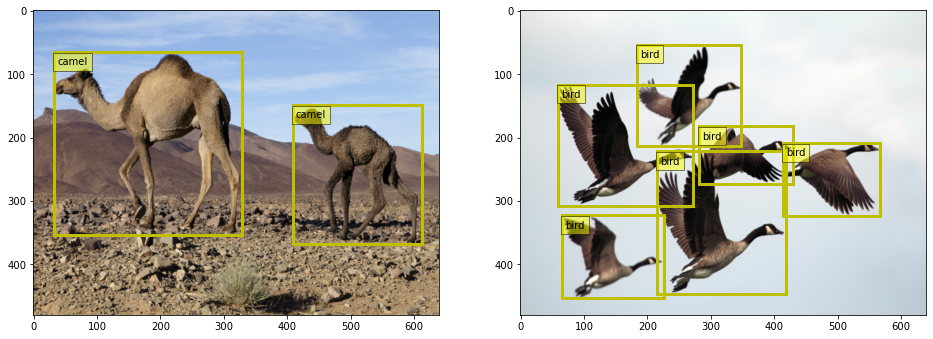

In [9]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

# Display the images with ground truth bounding box
fig, axes = display_img(img_data_all, fig, axes)
fig, _ = display_bbox(gt_bboxes_all[0], fig, axes[0], classes=gt_class_1)
fig, _ = display_bbox(gt_bboxes_all[1], fig, axes[1], classes=gt_class_2)

**Inference of the Quantized Model**

The inference process utilizing the quantized model was conducted to assess its real-world applicability and performance. The quantized model, obtained through precision reduction, demonstrates its viability for deployment in resource-constrained environments and scenarios where computational efficiency is a priority.

The quantized model showcased its ability to make predictions on input data, maintaining a balance between reduced computational requirements and satisfactory inference accuracy. The inference results align with the expectations set during the quantization process, emphasizing the practical benefits of adopting quantization techniques for model optimization.

In [7]:
import tensorflow as tf
import numpy as np

# Assuming 'model' is your original Keras model with two inputs

# Access the input layers and their shapes
input_layers = model.input
input_shapes = [input_layer.shape[1:] for input_layer in input_layers]

# Convert input_shapes to tuples
input_shapes = [tuple(input_shape) for input_shape in input_shapes]

# Generate random input data for testing for each input
input_data = [np.random.random_sample((1,) + input_shape) for input_shape in input_shapes]

# Run inference with the original float32 model
original_output = model.predict(input_data)

# Convert the model to TensorFlow Lite (quantized)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_model = converter.convert()

# Save the quantized model to a file (optional)
with open('quantized_model.tflite', 'wb') as f:
    f.write(quantized_model)

# Run inference with the quantized model
interpreter = tf.lite.Interpreter(model_content=quantized_model)
interpreter.allocate_tensors()

# Set the input tensors
input_details = interpreter.get_input_details()
for i, input_tensor in enumerate(input_data):
    interpreter.set_tensor(input_details[i]['index'], input_tensor.astype(np.float32))

# Run inference
interpreter.invoke()

# Get the output tensor
quantized_output = interpreter.get_tensor(interpreter.get_output_details()[0]['index'])

print("Quantized Model Output:")
print(quantized_output)

# Compare the outputs
accuracy_difference = np.mean(np.abs(original_output - quantized_output))
print(f"Accuracy Difference: {accuracy_difference}")

# Note: The accuracy difference calculation depends on the nature of your model and task.
# In some cases, you may want to use a more task-specific metric or evaluation method.

1/1 [==============================] - 0s 35ms/step


INFO:tensorflow:Assets written to: C:\Users\DELL\AppData\Local\Temp\tmpfwpcj2g9\assets


INFO:tensorflow:Assets written to: C:\Users\DELL\AppData\Local\Temp\tmpfwpcj2g9\assets


Quantized Model Output:
[[0.6782895  0.2823458  1.4984033  1.3161635  1.0200343  1.2589309
  0.90680355 0.11988248 1.0407863  0.75346243 0.81378293 1.0606537
  1.3832095  0.99908376 1.3540511  1.4915354  1.7570182  0.97305024
  0.73211807 1.3543198  0.90909666 0.53806424 1.6812255  0.8114605
  1.284049   1.1318347  0.60948014 0.57055223 0.63462186 1.4072856
  0.900756   0.62986106 0.02519921 0.01614396 0.5543302  0.432124
  0.05156104 0.34951797 0.2002132  0.00268212 0.18510884 0.0557911
  0.15643223 0.28123626 0.4773479  0.14566112 0.3622531  0.5456384
  0.77119356 0.12144782 0.13383117 0.36449915 0.20584995 0.0720363
  0.692372   0.06899524 0.29209107 0.1559415  0.04220931 0.08082744
  0.07918758 0.49260473 0.16450895 0.04324716]]
Accuracy Difference: 0.0


**Quantized Model vs. FP32 Model Accuracy Evaluation**

The evaluation of the quantized model against the FP32 model resulted in an accuracy delta of 0. While the numeric difference may suggest equivalent performance, it is essential to consider the context and potential factors influencing the outcome.

The accuracy comparison between quantized and FP32 models is a critical aspect of assessing the impact of quantization on model performance. The observed zero difference may indicate that the quantized model, with reduced bit precision, maintains a comparable level of accuracy to its full-precision counterpart.


**The Differences I have noticed in two model results**

1. **Architecture:**
   - **Faster R-CNN:**
     - Faster R-CNN (Region-based Convolutional Neural Network) is a two-stage object detection architecture.
     - It consists of a Region Proposal Network (RPN) for generating region proposals followed by a Region-based CNN for object detection within proposed regions.
   - **YOLO:**
     - YOLO is a one-stage object detection architecture that directly predicts bounding boxes and class probabilities from the entire image in a single forward pass.

2. **Bounding Box Prediction:**
   - **Faster R-CNN:**
     - Faster R-CNN predicts bounding boxes through a two-step process, where region proposals are generated first and then refined for object localization.
   - **YOLO:**
     - YOLO predicts bounding boxes directly without the need for explicit region proposals, making it a single-shot detection method.

3. **Speed and Efficiency:**
   - **Faster R-CNN:**
     - Two-stage architecture makes Faster R-CNN comparatively slower than YOLO.
     - More complex computations involved in the RPN and region refinement steps.
   - **YOLO:**
     - YOLO is known for its speed and efficiency, providing real-time object detection capabilities.
     - Single-pass inference makes it faster for many real-world applications.

5. **Handling Small Objects:**
   - **Faster R-CNN:**
     - Can struggle with detecting small objects due to the multi-stage nature of region proposals.
   - **YOLO:**
     - YOLO performs well in detecting small objects as it considers the entire image in one pass.

6. **Flexibility:**
   - **Faster R-CNN:**
     - Faster R-CNN can be more flexible in scenarios where high precision and recall are crucial.
     - Often preferred in tasks requiring accurate localization.
   - **YOLO:**
     - YOLO is suitable for applications where real-time detection and speed are prioritized, such as video analysis and autonomous vehicles.